In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statistics
import pandas as pd


# Clean up data
dump_arrival_raw = pd.read_csv('../../data/raw_data/03_Skip_deliveries_at_Mzedi.csv')


#Datetime conversion and sorting
dump_arrival_raw.date = pd.to_datetime(dump_arrival_raw.date)#.dt.tz_localize('Africa/Mbabane')
#dump_arrival_raw = dump_arrival_raw.sort_values('date')


#Delete 2010 & 2012 values
dump_arrival_raw.drop(dump_arrival_raw.loc[dump_arrival_raw.date < pd.to_datetime('2020-12-01')].index, inplace=True)
dump_arrival_raw.to_csv('../../data/interm_data/filtered_skip_deliveries_at_Mzedi.csv')

In [3]:
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statistics

numBin = 7
Q1 = 25
Q2 = 50
Q3 = 75

#Dump events & drop useless columns
dump_arrival = pd.read_csv('../../data/interm_data/filtered_skip_deliveries_at_Mzedi.csv')
dump_arrival = dump_arrival.drop(columns=['end','deviceid', 'start'])

#List of origin points
list_origin = dump_arrival.skip_origin.unique().astype(str)
list_origin = list_origin[list_origin!= 'nan']

#Datetime conversion and sorting
dump_arrival.date = pd.to_datetime(dump_arrival.date)#.dt.tz_localize('Africa/Mbabane')
dump_arrival = dump_arrival.sort_values('date')

## PIVOT TABLE
dump_arrival_new = dump_arrival.copy()
dump_arrival_new['values'] = 1
pivot_dump = pd.pivot_table(dump_arrival_new,values='values',index=['date'],columns='skip_origin',aggfunc=np.sum, fill_value=0)

print(dump_arrival.head(20))

     Unnamed: 0       date emptier type              skip_origin
120         120 2020-12-05          bcc                      NaN
103         103 2020-12-05          bcc            Bangwe market
104         104 2020-12-05          bcc           Mbayani market
105         105 2020-12-05          bcc             Limbe market
106         106 2020-12-05          bcc     Blantyre flea market
121         121 2020-12-05          bcc            Bangwe ground
112         112 2020-12-06          bcc           Kachere market
111         111 2020-12-06          bcc  Queens Guardian shelter
110         110 2020-12-06          bcc           Thawale market
108         108 2020-12-06          bcc             Limbe market
107         107 2020-12-06          bcc                      NaN
109         109 2020-12-06          bcc                      NaN
125         125 2020-12-07          bcc                 Chilobwe
124         124 2020-12-07          bcc                      NaN
123         123 2020-12-0

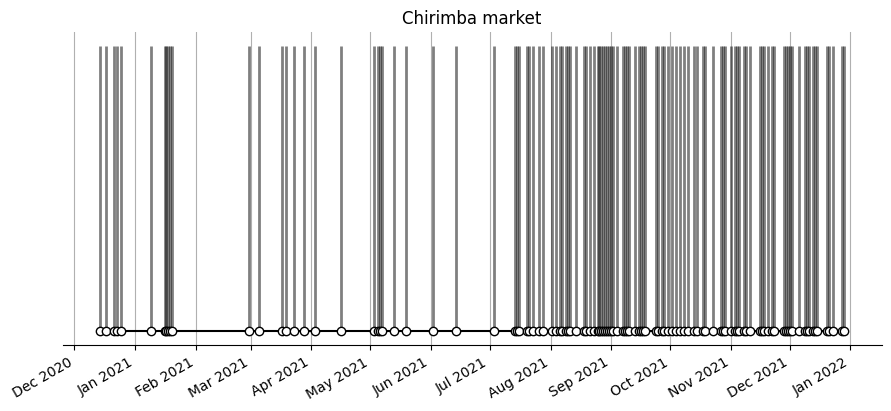

In [4]:
## TIMELINE PLOT
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)


dates_arrival_skip = pivot_dump[pivot_dump[list_origin[numBin]]!=0].index
plt.title(list_origin[numBin])

# dates_arrival_skip = pivot_dump[pivot_dump.sum(axis=1) != 0].index
# plt.title('Arrivals at Mzedi dump')

#plot timeline of dump arrivals from destination

levels = np.tile([1,1], int(np.ceil(len(dates_arrival_skip)/2)))[:len(dates_arrival_skip)] #+1,-1 stems
ax.vlines(dates_arrival_skip, 0, levels, linestyle='solid', color=[(0, 0, 0, 0.5)], linewidth=2)  # The vertical stems
ax.plot(dates_arrival_skip, np.zeros_like(dates_arrival_skip), "-o", color="k", markerfacecolor="w")  #Tick plot
ax.yaxis.set_visible(False) #Hide y axis
ax.spines[["left", "top", "right"]].set_visible(False)#Hide other lines
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) #Month interval labels
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
ax.grid(True)

plt.setp(ax.get_xticklabels(), rotation=30, ha="right")
plt.show() #Plot

In [5]:
#Period start !!still change so that a different period time for each skip
time_start = pd.to_datetime('2021-10-01')
time_end = pd.to_datetime('2021-09-01')


## Individual skip analysis: timeline, average, max, min, pattern <-- for specific periods to match skip raw data periods

## !!ADD VARIABILITY (HISTOGRAM, VARIANCE) AS A MEASURE OF REGULARITY
## interquartile range (IQR) instead of the variance to account for outliers
##  Five Number Summary

#start,end,min, max, mean, median, mode
#period_start,period_end,min_period,max_period,median_period,mode_period
skip_dates_agg = []
current_skip_day_cum_joined= pd.DataFrame()
skip_data_stats = pd.DataFrame(np.zeros([len(list_origin),10]),
                         columns=['start','end','#','min','mean','Q1','median','Q3','max','std'], index=list_origin)
for columns in list_origin: #pivot_dump
    current_skip = pivot_dump[columns][pivot_dump[columns]!=0]
    #print(current_skip)
    list_days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    current_skip_day_index= current_skip.index.dayofweek.to_list()
    current_skip_day_cum=[]
    for j in range(7):
        current_skip_day_cum.append(current_skip_day_index.count(j)) #Counts number of arrivals for each weekday
    current_skip_day_cum_joined[columns] = current_skip_day_cum
    diff_0 = (current_skip[current_skip>1]-1).sum()
    current_skip_index_diff = current_skip.index.to_series().diff().dt.days.dropna()
    listofzeros = [0] * diff_0
    zeropd = pd.DataFrame(listofzeros)#.squeeze()
    try:
        if not zeropd.empty:
            current_skip_index_diff = pd.concat([current_skip_index_diff,zeropd])
    except:
        print('except:')
        print(columns)
        print(zeropd)
        
    current_skip_index_diff = current_skip_index_diff.squeeze()
    skip_dates_agg.append(current_skip_index_diff)

    skip_data_stats.loc[columns,'start'] = current_skip.index.to_series().min()
    skip_data_stats.loc[columns,'end'] = current_skip.index.to_series().max()
    try:
        skip_data_stats.loc[columns,'#'],skip_data_stats.loc[columns,'mean'],skip_data_stats.loc[columns,'std'], skip_data_stats.loc[columns,'min'],skip_data_stats.loc[columns,'Q1'],skip_data_stats.loc[columns,'median'],skip_data_stats.loc[columns,'Q3'],skip_data_stats.loc[columns,'max']=current_skip_index_diff.describe(percentiles = [Q1/100,Q2/100,Q3/100]) 
    except:
        skip_data_stats.loc[columns,'#'] = len([current_skip_index_diff])
        skip_data_stats.loc[columns,'mean'],skip_data_stats.loc[columns,'std'], skip_data_stats.loc[columns,'min'],skip_data_stats.loc[columns,'Q1'],skip_data_stats.loc[columns,'median'],skip_data_stats.loc[columns,'Q3'],skip_data_stats.loc[columns,'max'] = [current_skip_index_diff]*7

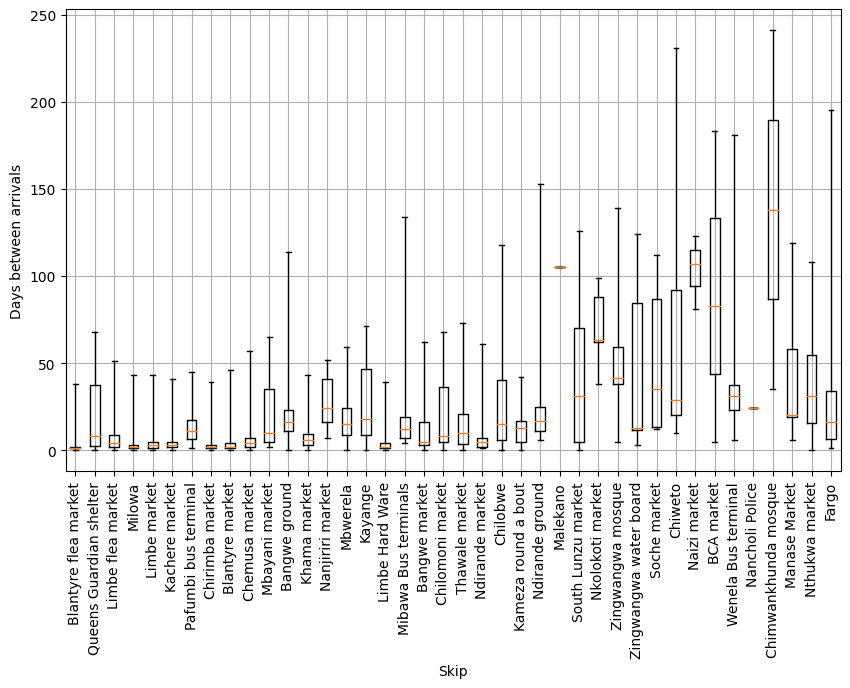

                                       start                  end      #  \
Blantyre flea market     2020-12-05 00:00:00  2021-12-30 00:00:00  205.0   
Queens Guardian shelter  2020-12-06 00:00:00  2021-11-27 00:00:00   18.0   
Limbe flea market        2020-12-07 00:00:00  2021-12-24 00:00:00   58.0   
Milowa                   2020-12-10 00:00:00  2021-12-31 00:00:00  146.0   
Limbe market             2020-12-05 00:00:00  2021-12-27 00:00:00   84.0   
Kachere market           2020-12-06 00:00:00  2021-12-28 00:00:00   73.0   
Pafumbi bus terminal     2020-12-07 00:00:00  2021-12-27 00:00:00   28.0   
Chirimba market          2020-12-14 00:00:00  2021-12-29 00:00:00  123.0   
Blantyre market          2020-12-15 00:00:00  2021-12-29 00:00:00  105.0   
Chemusa market           2020-12-11 00:00:00  2021-12-23 00:00:00   59.0   
Mbayani market           2020-12-05 00:00:00  2021-11-26 00:00:00   17.0   
Bangwe ground            2020-12-05 00:00:00  2021-12-12 00:00:00   13.0   
Khama market

In [6]:
## Box plots & print stats summary

fig, ax = plt.subplots(figsize=(10, 6))
ax.boxplot(skip_dates_agg, whis = 1000)
plt.xlabel('Skip')
plt.ylabel('Days between arrivals')
ax.set_xticks(np.arange(1,len(skip_data_stats.index)+1),labels=skip_data_stats.index)
plt.xticks(rotation=90)
plt.grid()
plt.show()
print(skip_data_stats)
#skip_data_stats.to_csv('../../data/interm_data/mzedi_entry_skip_data_stats.csv')

In [22]:
skip_data_stats.Q1

Blantyre flea market         1.00
Queens Guardian shelter      2.50
Limbe flea market            2.00
Milowa                       1.00
Limbe market                 1.00
Kachere market               2.00
Pafumbi bus terminal         6.50
Chirimba market              1.00
Blantyre market              1.00
Chemusa market               2.00
Mbayani market               5.00
Bangwe ground               11.00
Khama market                 3.00
Nanjiriri market            16.00
Mbwerela                     8.50
Kayange                      8.50
Limbe Hard Ware              1.00
Mibawa Bus terminals         7.00
Bangwe market                3.00
Chilomoni market             5.00
Thawale market               3.75
Ndirande market              2.00
Chilobwe                     6.00
Kameza round a bout          5.00
Ndirande ground             10.75
Malekano                   105.00
South Lunzu market           5.00
Nkolokoti market            62.00
Zingwangwa mosque           38.25
Zingwangwa wat

In [8]:
dump_arrival.date.to_list().index(pd.Timestamp('2021-01-20 00:00:00'))

177

[6, 6, 13, 6, 3, 6, 4, 6, 5, 5, 3, 1, 6, 4, 6, 4, 4, 4, 4, 4, 1, 5, 2, 7, 6, 5, 6, 7, 7, 5, 1, 4, 6, 4, 6, 5, 4, 3, 7, 14, 2, 4, 5, 5, 6, 4, 7, 6, 6, 6, 5, 6, 5, 2, 4, 6, 4, 5, 4, 5, 4, 3, 5, 5, 2, 4, 7, 5, 2, 4, 4, 1, 6, 7, 1, 4, 4, 4, 6, 6, 4, 2, 4, 4, 4, 7, 6, 2, 5, 4, 4, 3, 7, 6, 1, 6, 5, 4, 2, 6, 1, 5, 6, 3, 6, 3, 3, 7, 6, 6, 5, 5, 7, 5, 3, 6, 7, 14, 5, 6, 6, 7, 8, 1, 4, 5, 1, 6, 3, 7, 7, 2, 6, 5, 4, 3, 3, 4, 5, 5, 6, 6, 9, 6, 15, 5, 14, 2, 11, 4, 10, 6, 9, 12, 11, 7, 1, 4, 4, 5, 2, 2, 7, 6, 8, 7, 6, 9, 6, 4, 9, 7, 6, 5, 3, 4, 3, 7, 7, 7, 7, 6, 6, 6, 3, 5, 8, 7, 8, 5, 3, 6, 7, 7, 6, 6, 2, 6, 7, 7, 6, 5, 6, 4, 6, 4, 7, 7, 7, 3, 4, 5, 7, 3, 6, 6, 6, 7, 3, 6, 6, 6, 4, 7, 5, 5, 7, 3, 7, 3, 6, 4, 6, 7, 6, 3, 4, 6, 3, 7, 6, 7, 2, 6, 6, 6, 6, 4, 5, 4, 6, 6, 6, 1, 7, 6, 6, 6, 4, 7, 7, 3, 6, 7, 5, 5, 3, 2, 6, 6, 6, 6, 3, 3, 7, 7, 4, 6, 6, 3, 7, 2, 2, 8, 5, 2, 4, 7, 6, 6, 2, 4]
5.5


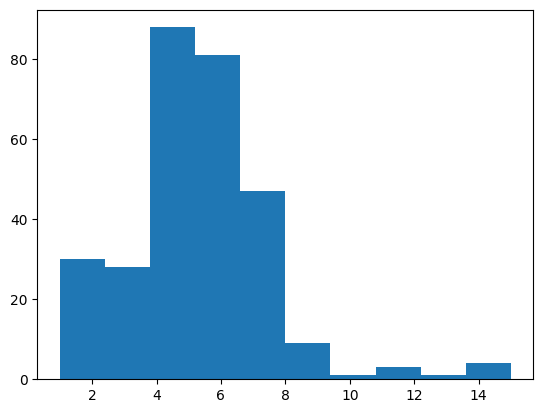

In [9]:
num_colls = []
for i in dump_arrival.date.unique():
    num_colls.append(dump_arrival.date.to_list().count(i))
    
print(num_colls)
print(statistics.median(num_colls))
plt.hist(num_colls)
plt.show()

177


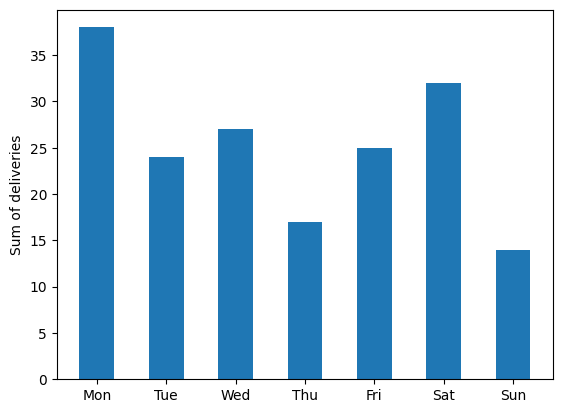

In [10]:
#Dump analysis: bar plot, pattern (week), average per week
#Day of week:
list_days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
dump_arrival_day_index= dump_arrival.date.dt.dayofweek.to_list()[0:177]
print(len(dump_arrival_day_index))

dump_arrival_day_cum=[]
for j in range(7):
    dump_arrival_day_cum.append(dump_arrival_day_index.count(j)) #Counts number of arrivals for each weekday

# fig, ax = plt.subplots()
# ax.bar(list_days, dump_arrival_day_cum)
# ax.grid()
# plt.xlabel('Day of week')
# plt.ylabel('Sum of deliveries over period')
# plt.show()

fig,ax = plt.subplots()
plt.bar(list_days,dump_arrival_day_cum, width=0.5)
plt.ylabel('Sum of deliveries')
plt.show()

1529


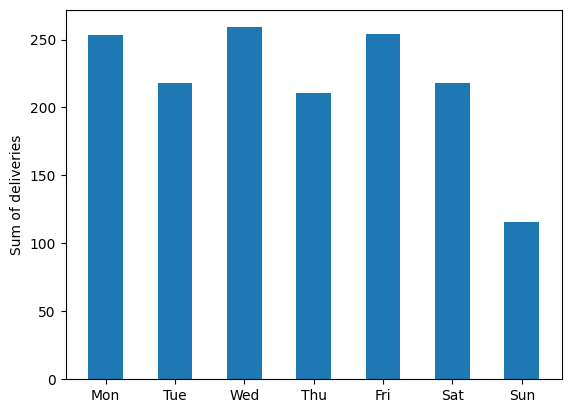

In [11]:
#Dump analysis: bar plot, pattern (week), average per week
#Day of week:
list_days = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
dump_arrival_day_index= dump_arrival.date.dt.dayofweek.to_list()
print(len(dump_arrival_day_index))
dump_arrival_day_cum=[]
for j in range(7):
    dump_arrival_day_cum.append(dump_arrival_day_index.count(j)) #Counts number of arrivals for each weekday

# fig, ax = plt.subplots()
# ax.bar(list_days, dump_arrival_day_cum)
# ax.grid()
# plt.xlabel('Day of week')
# plt.ylabel('Sum of deliveries over period')
# plt.show()

fig,ax = plt.subplots()
plt.bar(list_days,dump_arrival_day_cum, width=0.5)
plt.ylabel('Sum of deliveries')
plt.show()

In [12]:
len(dump_arrival_day_index)

1529

In [13]:
len(dump_arrival.date.dt.dayofweek.to_list()[177:-1])

1351

In [14]:
len(dump_arrival.date.dt.dayofweek.to_list()[0:177])

177

In [15]:
177+1350

1527

In [16]:
len(dump_arrival)

1529